In [210]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [49]:
def sample_onestep(initial_state, num_states):
    state = initial_state
    next_state = np.random.choice([-1,1],1).item() + state
    reward = 0
    terminate = False
    if next_state == num_states+1:
        reward = 1
        terminate = True
    if next_state == 0:
        terminate = True
    return reward, next_state, terminate     

In [50]:
def sample_trajectory(initial_state, num_states, max_steps=100):
    path = [initial_state]
    state = initial_state
    for i in range(max_steps):
        r, s, t = sample_onestep(state, num_states)
        path.extend([r,s])
        if t:
            break
        else:
            state = s
    return path

In [205]:
def MonteCarlo(alpha, initial_state, num_states, num_iter=1000):
    v = np.array([[0.5 for _ in range(num_states)]])
    for i in range(num_iter):
        path = sample_trajectory(initial_state, num_states)
        pos = len(path) - 3
        g = 0
        v_new = list(v[-1])
        while pos>=0:
            s = path[pos]
            r = path[pos+1]
            g += r
            v_new[s-1] = v_new[s-1] + alpha*(g - v_new[s-1])
            pos -= 2
        v = np.append(v,[v_new],axis=0)
    return v

In [206]:
def RMS(v):
    m = np.array([1,2,3,4,5])/6.0
    return np.sqrt(((v-m)**2).mean(axis=1))

In [272]:
num_runs = 100
num_walks = 150
df_plot_MC = pd.DataFrame()
for alpha in [0.01, 0.02, 0.03, 0.04]:
    err = []
    vlist = []
    for i in range(num_runs):
        v = MonteCarlo(alpha,3,5,num_iter=num_walks)
        vlist.append(v)
        err.append(RMS(v))
    df = pd.DataFrame(np.array(err).mean(axis=0))
    df.columns=[alpha]
    df_plot_MC = pd.concat([df_plot_MC, df],axis=1)

<AxesSubplot:>

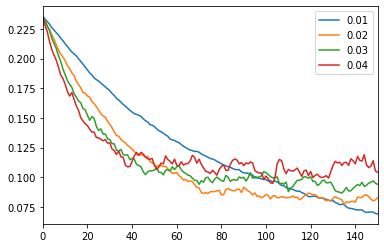

In [273]:
df_plot_MC.plot()

In [274]:
def TD0(alpha, gamma, initial_state, num_states, num_iter=1000):
    v = np.array([[0.5 for _ in range(num_states)]])
    state = initial_state
    terminate = False
    for i in range(num_iter):
        v_new = list(v[-1])
        while True:
            reward, next_state, terminate = sample_onestep(state, num_states)
            if not terminate:
                v_new[state-1] = v_new[state-1] + alpha*(reward + gamma*v_new[next_state-1] - v_new[state-1])
                state = next_state
            else:
                v_new[state-1] = v_new[state-1] + alpha*(reward - v_new[state-1])
                break
        v = np.append(v, [v_new], axis=0)
        state = initial_state
        
    return v

In [275]:
num_runs = 100
num_walks = 150
df_plot_TD = pd.DataFrame()
for alpha in [0.02, 0.05, 0.1, 0.15]:
    vlist = []
    err = []
    for i in range(num_runs):
        v = TD0(alpha,1,3,5,num_iter=num_walks)
        vlist.append(v)
        err.append(RMS(v))
    df = pd.DataFrame(np.array(err).mean(axis=0))
    df.columns=[alpha]
    df_plot_TD = pd.concat([df_plot_TD, df],axis=1)

<AxesSubplot:>

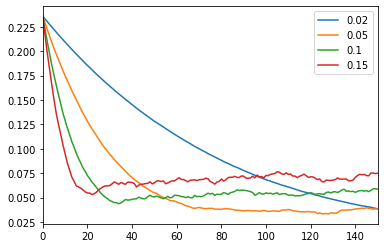

In [276]:
df_plot_TD.plot()

In [277]:
v_est = []
for v in vlist:
    v_est.append(v[-1])

In [284]:
np.array(v_est).mean(axis=0)

array([0.12816479, 0.29583726, 0.50110057, 0.71187462, 0.87715257])

In [285]:
df_plot_MC.columns = [str(i) + '_MC' for i in df_plot_MC.columns]
df_plot_TD.columns = [str(i) + '_TD' for i in df_plot_TD.columns]


In [286]:
df_plot = pd.concat([df_plot_MC, df_plot_TD], axis = 1)

<AxesSubplot:>

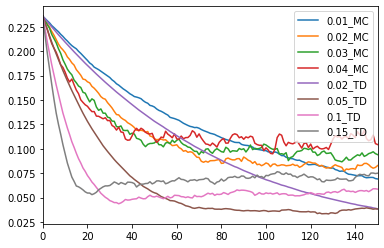

In [287]:
df_plot.plot()

In [366]:
l = np.array([1,2,3])
l[1] += 0.6

In [367]:
l[1]

2

In [384]:
def MonteCarlo_batch(alpha, initial_state, num_states, batch_size=10, num_iter=1000):
    v = np.array([[0.5 for _ in range(num_states)]])
    increments = np.array([0.0 for _ in range(num_states)])
    
    for i in range(num_iter):
        path = sample_trajectory(initial_state, num_states)
        pos = len(path) - 3
        g = 0
        while pos>=0:
            s = path[pos]
            r = path[pos+1]
            g += r
            increments[s-1] += (g - v[-1][s-1])
            pos -= 2
            
        if (i+1) % batch_size == 0:
            # batch update v
            v = np.vstack((v, v[-1]+alpha*increments))
            increments = np.array([0.0 for _ in range(num_states)])
    return v

In [387]:
v = MonteCarlo_batch(0.02, 3, 5)

In [388]:
v[-1]

array([0.20832932, 0.3174755 , 0.55553145, 0.7636414 , 0.86565686])

In [389]:
def TD0_batch(alpha, gamma, initial_state, num_states, batch_size=10, num_iter=1000):
    v = np.array([[0.5 for _ in range(num_states)]])
    state = initial_state
    terminate = False
    increments = np.array([0.0 for _ in range(num_states)])
    
    for i in range(num_iter):
        while True:
            reward, next_state, terminate = sample_onestep(state, num_states)
            if not terminate:
                increments[state-1] += (reward + gamma*v[-1][next_state-1] - v[-1][state-1])
                state = next_state
            else:
                increments[state-1] += (reward - v[-1][state-1])
                break
                
        if (i+1) % batch_size == 0:
            # batch update v
            v = np.vstack((v, v[-1]+alpha*increments))
            increments = np.array([0.0 for _ in range(num_states)])
        
        state = initial_state
        
    return v

In [395]:
v = TD0_batch(0.01, 1, 3, 5)

In [396]:
v[-1]

array([0.17075977, 0.31764867, 0.48597783, 0.6453054 , 0.80574366])